### Investigate the influence of hyper parameters

goals:
- study the influence
- justify why this is happening
- find best parameters

investigated parameters (we build the list as we go)

- pb_c_base (in progress) so far lowering to 500 led to better results 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True, font_scale=1)
import itertools
# marker = itertools.cycle(("o", "^", "s")) 
marker = itertools.cycle((None,)) 
markevery = 20

In [3]:
folders = ['new_section_baseline', 'pb_c_base_500','pb_c_base_100','very_different_exploration']
files = [['Tensorboard_data/{}/1/Total reward.csv'.format(folder),
         'Tensorboard_data/{}/2/Total reward.csv'.format(folder),
         'Tensorboard_data/{}/3/Total reward.csv'.format(folder),
        ] for folder in folders]

In [4]:
max_length = 100
n_tests = 1
data = np.array([[np.loadtxt(tb_file, delimiter=',', skiprows=1)[:max_length,2] 
                  for tb_file in file] 
                  for file in files])
data_mean = np.mean(data, axis=1)
data_std = np.std(data, axis=1)

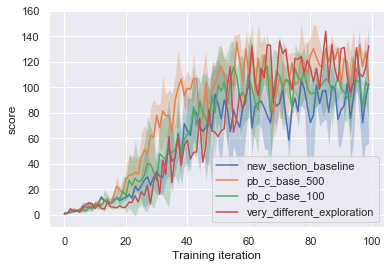

In [5]:
fig, ax = plt.subplots()
clrs = sns.color_palette(n_colors=len(folders))

epochs = list(range(max_length))
for i in range(len(folders)):
    ax.plot(epochs, data_mean[i], label=folders[i], marker=next(marker), markevery=markevery, c=clrs[i])
    ax.fill_between(epochs, data_mean[i]-data_std[i], data_mean[i]+data_std[i] ,alpha=0.3, facecolor=clrs[i])
ax.set_xlabel('Training iteration', color='k')  
ax.set_ylabel('score', color='k') 
ax.legend()
plt.show()

# fig.savefig('dense.png', format='png', dpi=600)